In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.tfmc90 import Phototransduction
from jaxley_mech.channels.lk04 import h, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak


In [2]:
def parse_s(s, to_records=[]):
    return {key: s[i].T[:-1] for (i, key) in enumerate(to_records)}

Here we reproduced TEA-induced oscillatory action potentials in Rod disrupted (hyperpolarized) by two 20ms light pulses over 30 seconds.

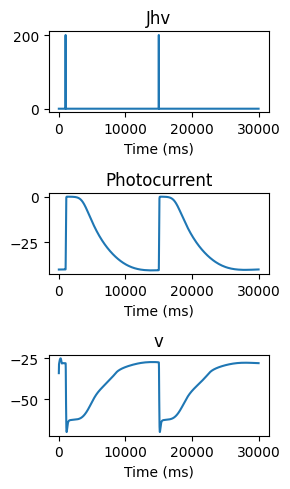

In [3]:
fig, ax = plt.subplot_mosaic([["Jhv"], ["Photocurrent"], ["v"]], figsize=(3, 5))


params = {
    "length": 10,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.32e-3,

    "Ca_gCa": 2.2e-3, 
    "eCa": 40,
    
    "h_gh": 2.5e-3,
    "h_eh": -32,
}

to_records = [
    "iPhoto", # photocurrent in outer segment
    "v", # photoresponse in inner segment
] # albeit we model it in a single compartment

for itensity in [200]:
    pre_light_time_1 = 1000  # ms
    pre_light_time_2 = 15000 # ms
    light_on_time = 20  # ms
    total_time = 30000 # ms
    dt = 0.1 # ms
    time_steps = int(total_time / dt)
    time = jnp.linspace(0, total_time, time_steps)

    cell = Compartment()
    cell.insert(Phototransduction())
    cell.insert(h())
    cell.insert(Kx())
    cell.insert(Kv())
    cell.insert(Ca())
    cell.insert(ClCa())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)
    
    cell.init_states()
    
    Jhv = jnp.zeros(time_steps)
    light_on_start_1 = int(pre_light_time_1 / dt)
    light_on_end_1 = int((pre_light_time_1 + light_on_time) / dt)


    light_on_start_2 = int( pre_light_time_2 / dt)
    light_on_end_2 = int((pre_light_time_2 + light_on_time) / dt)
    Jhv = Jhv.at[light_on_start_1:light_on_end_1].set(itensity)
    Jhv = Jhv.at[light_on_start_2:light_on_end_2].set(itensity)
    Jhv = Jhv.reshape(-1,1)


    # This utilizes an experimental feature of jaxley in the external_input branch
    cell.external_states = {
        "Phototransduction_Jhv": Jhv,    
    }

    for rec in to_records:
        cell.record(rec, verbose=False)

    # Run the simulation
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = parse_s(s, to_records)

    ax["Jhv"].plot(time, Jhv, label=f"{itensity} R*/ms")
    ax["Photocurrent"].plot(time, s["iPhoto"], label=f"{itensity} R*/s")
    ax["v"].plot(time, s["v"], label=f"{itensity} R*/s")

for key in ax.keys():
    ax[key].set_xlabel("Time (ms)")
    ax[key].set_title(key)

fig.tight_layout()